# Solving orbital equations with different algorithms

Solves and animates the two-body orbital problem in Cartesian coordinates

* Last revised 27-Apr-2019 by Richard Mueller (mueller.415@osu.edu).

We consider energy plots and orbital solutions in Cartesian coordinates for solar orbits, with potential

$\begin{align}
   U(r) = -\frac{G m_1 m_2}{r}
\end{align}$

for different ODE solution algorithms.  The `solve_ivp` function can itself be specified to use different solution methods (with the `method` keyword).  Here we will set it by default to use 'RK23', which is a variant on the Runge-Kutta second-order algorithm.  Second-order in this context means that the accuracy of a calculation will improve by a factor of $10^2 = 100$ if $\Delta t$ is reduced by a factor of ten. 


### Solve for the equations of motion
The kinetic energy is:

$\begin{align}
   T = \frac12 (m_1(\dot x_1^2 + \dot y_1^2) + m_2(\dot x_2^2 + \dot y_2^2))
\end{align}$

making the Lagrangian

$\begin{align}
  \mathcal{L} = T - U = \frac12 (m_1(\dot x_1^2 + \dot y_1^2) + m_2(\dot x_2^2 + \dot y_2^2)) + \frac{G m_1 m_2}{r}
\end{align}$

The Euler-Lagrange equation is

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot q_i} = \frac{\partial\mathcal L}{\partial q_i}
\end{align}$

Taking these derivatives,

$\begin{align}
 \frac{\partial\mathcal L}{\partial q_i} = m_i \ddot q_i
\end{align}$

For $x_1$ and $y_1$,

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot q_2} = -\frac{Gm_1m_2(x_1 - x_2)}{((x_1-x_2)^2 + (y_1-y_2)^2)^{3/2}}
\end{align}$

For $x_2$ and $y_2$,

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot q_2} = \frac{Gm_1m_2(x_1 - x_2)}{((x_1-x_2)^2 + (y_1-y_2)^2)^{3/2}}
\end{align}$

Solving, we find:

For $x_1$ and $y_1$,

$\begin{align}
 m_1 \ddot q_1 = -\frac{Gm_1m_2(x_1 - x_2)}{\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}}
\end{align}$

For $x_2$ and $y_2$,

$\begin{align}
 m_1 \ddot q_2 = \frac{Gm_1m_2(x_1 - x_2)}{\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}}
\end{align}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [3]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = G*m1*m2 / r.  Several algorithms for integration of 
    ordinary differential equations are available in the following section. 
    """
    
    def __init__(self, m1=1., m2=1., G=1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dr/dt d^2r/dt^2 dphi/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            8-component vector with 
            y[0] = dx1/dt, y[1] = dy1/dt,
            y[2] = dx2/dt, y[3] = dy2/dt,           
            y[4] = d^2x1/dt^2, y[5] = d^2y1/dt^2 
            y[6] = d^2x2/dt^2, y[7] = d^2y2/dt^2
            
        """
        x1, y1, x2, y2, dx1, dy1, dx2, dy2 = y
        
        rSquared = ((x1-x2)**2. + (y1-y2)**2.)**(1.5)
        
        ddx1 = -G*self.m2*(x1-x2) / rSquared     
        ddy1 = -G*self.m2*(y1-y2) / rSquared 
        ddx2 = G*self.m1*(x1-x2) / rSquared
        ddy2 = G*self.m1*(y1-y2) / rSquared
        
        return dx1, dy1, dx2, dy2, ddx1, ddy1, ddx2, ddy2
    
    
    def solve_ode(self, t_pts, q_0, dq_0,
                  method='RK23',
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        y = q_0 + dq_0
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        x1, y1, x2, y2, dx1, dy1, dx2, dy2 = solution.y
        
        return [(x1, y1, x2, y2), (dx1, dy1, dx2, dy2)]
    
    
    def energy(self, q, dq):
        """Evaluate the energy as a function of time"""
        x1, y1, x2, y2, dx1, dy1, dx2, dy2 = q + dq
        
        r = ((x1-x2)**2. + (y1-y2)**2.)**(.5)
        
        return .5*(self.m1*(dx1**2. + dy1**2.) + self.m2*(dx2**2. + dy2**2.)) \
                - self.G*self.m1*self.m2*(1/r)

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Plot orbit for m1 >> m2

In [5]:
# Orbit Parameters
m1 = 1000.
m2 = .1
G = .1
o1 = Orbit(m1=m1, m2=m2, G=G)

# Plotting time 
t_start = 0.
t_end = 1.
delta_t = 0.01
t_pts = np.arange(t_start, t_end+delta_t, delta_t)

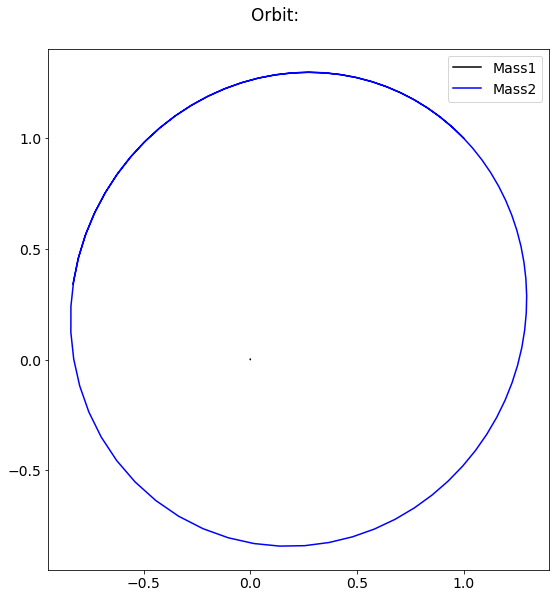

In [6]:
########## Initial Conditions
x1_0 = 0.
dx1_0 = 0.
y1_0 = 0.
dy1_0 = 0.

x2_0 = 1.
dx2_0 = -5.
y2_0 = 1.
dy2_0 = 5.

q_0 = [x1_0, y1_0, x2_0, y2_0]
dq_0 = [dx1_0, dy1_0, dx2_0, dy2_0]

########## Solve for eqns. of motion
q, dq = o1.solve_ode(t_pts,q_0, dq_0)

########## Plot
fig_1 = plt.figure(figsize=(8,8))

overall_title = 'Orbit:  ' + \
                '\n'     # \n means a new line (adds some space here)
fig_1.suptitle(overall_title, va='baseline')

ax_1a = fig_1.add_subplot(1,1,1)
ax_1a.plot(q[0], q[1], color='black', label='Mass1')
ax_1a.plot(q[2], q[3], color='blue', label='Mass2')
ax_1a.legend()

fig_1.tight_layout()

## Leapfrog & Euler methods: Checking energy conservation

We will compare the RK23 output with the crudest algorithm, Euler's method, which is first order, and a second-order algorithm called Leapfrog, which is designed to be precisely <em>time-reversal invariant</em>.  This property guarantees conservation of energy, which is not true of the other algorithms we consider.

To solve the differential equations for orbits, we have defined the $\mathbf{q}$ 
and $d\mathbf{q}/dt$ coordinate vectors as

$\begin{align}
  \mathbf{q} = \left(\begin{array}{c} x1(t) \\ y1(t) \\ x2(t) \\ y2(t)  \end{array} \right) 
  \qquad
  \frac{d\mathbf{q}}{dt} 
       = \left(\begin{array}{c} \dot x1(t) \\ \dot y1(t) \\ \dot x2(t) \\ \dot y2(t) \end{array} \right) 
\end{align}$


Then Euler's method can be written as a simple prescription to obtain $\mathbf{q}_{i+1}$ 
from $\mathbf{q}_i$, where the subscripts label the elements of the `t_pts` array: 
$\mathbf{q}_{i+1} = \mathbf{q}_i + \left(d\mathbf{q}/dt\right)_i \Delta t$, or, by components:

$\begin{align}
   q[j]_{i+1} &= q[j]_i + \frac{d\mathbf{q}_i[j]}{dt}  \Delta t  \\
   \dot q[j]_{i+1} &= \dot q[j]_{i} + \frac{d\mathbf{\dot q}_i[j]^2}{dt^2}  \Delta t \\
\end{align}$

for each j.

The leapfrog method does better by evaluating $\dot r$ at a halfway time step before and after the $r$ evaluation, 
which is both more accurate and incorporates time reversal: 

$\begin{align}
   \dot q[j]_{i+1/2} &= \dot q[j]_{i} + \frac{d\mathbf{\dot q}_i[j]}{dt}  \Delta t/2 \\
   q[j]_{i+1} &= q[j]_i + \dot q[j]_{i+1/2}  \Delta t  \\
   \dot q[j]_{i+1} &= \dot q[j]_{i+1/2} + \frac{d\mathbf{\dot q}_{i+1}[j]}{dt}  \Delta t/2 \\
\end{align}$

A third method is the second-order Runge-Kutta algorithm, which we invoke from `solve_ivp` as `RK23`. 
It does not use a fixed time-step as in our "homemade" implementations, so there is not a direct 
comparison, but we can still check if it conserves energy.

In [7]:
########## Create Subclass to store solving methods
class orbitSolvers(Orbit):
    
    def __init__(self, m1=1., m2=2., G=1.):
        Orbit.__init__(self, m1, m2, G)
    
    def EulerSolve(self, t_pts, q_0, dq_0):
        """
        Solve the ODE given initial conditions with the Euler method.
        The accuracy is determined by the spacing of times in t_pts.
        """
        dt = t_pts[1] - t_pts[0]
        num_t_pts = len(t_pts)    # length of the array t_pts
        
        ###### initialize the arrays for coordinates with zeros
        num_vars = int(len(q_0))       # number of variables
        
        # q = (x1, y1, x2, y2)         dq = (dx1, dy1, dx2, dy2)
        q = np.zeros(num_vars * num_t_pts)
        dq = np.zeros(num_vars * num_t_pts)
        
        ###### Set initial conditions
        for i in np.arange(num_vars):
            n = i*num_t_pts
            q[n] = q_0[i] 
            dq[n] = dq_0[i]

        ###### Step through the differential equation
        for i in np.arange(num_t_pts-1):
            t = t_pts[i]
            
            ### Combining coords so we can use method dy_dt
            # qI = (x1, y1, x2, y2, dx1, dy1, dx2, dy2
            qI = [q[i], q[num_t_pts + i],
                  q[2*num_t_pts + i], q[3*num_t_pts + i],
                  dq[i], dq[num_t_pts + i],
                  dq[2*num_t_pts + i], dq[3*num_t_pts + i]]

            for j in np.arange(num_vars):
                varIn = j * num_t_pts    # Start index of varible
                ### Compute next variable step
                q[varIn+i+1] = q[varIn + i] + self.dy_dt(t,qI)[j] * dt
                ### Compute next derivative step
                dq[varIn+i+1] = dq[varIn + i] + self.dy_dt(t,qI)[num_vars + j] * dt

        ### Break up and return in q & qdot arrays
        return [(q[0:num_t_pts], 
                 q[num_t_pts:2*num_t_pts],
                 q[2*num_t_pts:3*num_t_pts], 
                 q[3*num_t_pts:4*num_t_pts]),
                
                (dq[0:num_t_pts], 
                 dq[num_t_pts:(2*num_t_pts)],
                 dq[2*num_t_pts:3*num_t_pts], 
                 dq[3*num_t_pts:4*num_t_pts])]
    
    
    def LeapFrog(self, t_pts, q_0, dq_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        dt = t_pts[1] - t_pts[0]
        num_t_pts = len(t_pts)    # length of the array t_pts
        
        ###### initialize the arrays for coordinates with zeros
        num_vars = int(len(q_0))       # number of variables
            
        # q = (x1, y1, x2, y2)         dq = (dx1, dy1, dx2, dy2)
        q = np.zeros(num_vars * num_t_pts)
        dq = np.zeros(num_vars * num_t_pts)
        dq_half = np.zeros(num_vars * num_t_pts)
            
        ###### Set initial conditions
        for i in np.arange(num_vars):
            n = i*num_t_pts
            q[n] = q_0[i] 
            dq[n] = dq_0[i]
    
        ###### Step through the differential equation
        for i in np.arange(num_t_pts-1):
            t = t_pts[i]
                
            ### Combining coords so we can use method dy_dt
            # qI = (x1, y1, x2, y2, dx1, dy1, dx2, dy2)
            qI = [q[i], q[num_t_pts + i],
                  q[2*num_t_pts + i], q[3*num_t_pts + i],
                  dq[i], dq[num_t_pts + i],
                  dq[2*num_t_pts + i], dq[3*num_t_pts + i]]
              
            ### Compute dq_half[i] and q[i+1]
            for j in np.arange(num_vars):
                varIn = j * num_t_pts    # Start index of varible
                
                ### Compute half-derivative step
                dq_half[varIn+i] = dq[varIn + i] \
                                    + self.dy_dt(t,qI)[num_vars + j] * dt/2.
                
                ### Compute next variable step
                q[varIn+i+1] = q[varIn + i] + dq_half[varIn+i] * dt 
                  
            q2I = [q[i+1], q[num_t_pts + i+1],
                   q[2*num_t_pts + i+1], q[3*num_t_pts + i+1],
                   dq[i], dq[num_t_pts + i],
                   dq[2*num_t_pts + i], dq[3*num_t_pts + i]]
            
            for j in np.arange(num_vars):
                varIn = j * num_t_pts    # Start index of varible
                
                ### Compute next half-derivative step
                dq[varIn+i+1] = dq_half[varIn + i] \
                                    + self.dy_dt(t,q2I)[num_vars + j] * dt/2.
                    
        ### Break up and return in q & qdot arrays
        return [(q[0:num_t_pts], 
                 q[num_t_pts:2*num_t_pts],
                 q[2*num_t_pts:3*num_t_pts], 
                 q[3*num_t_pts:4*num_t_pts]),
                    
                (dq[0:num_t_pts], 
                 dq[num_t_pts:(2*num_t_pts)],
                 dq[2*num_t_pts:3*num_t_pts], 
                 dq[3*num_t_pts:4*num_t_pts])]

In [24]:
########## Set up parameters & initial conditions
# Orbit Parameters
m1 = 1000.
m2 = .1
G = .1
o1 = Orbit(m1=m1, m2=m2, G=G)

# Plotting time 
t_start = 0.
t_end = 20.
delta_t = 0.01
t_pts = np.arange(t_start, t_end+delta_t, delta_t)

########## Initial Conditions
x1_0 = 0.
dx1_0 = 0.
y1_0 = 0.
dy1_0 = 0.

x2_0 = 1.
dx2_0 = -5.
y2_0 = 1.
dy2_0 = 5.

q_0 = [x1_0, y1_0, x2_0, y2_0]
dq_0 = [dx1_0, dy1_0, dx2_0, dy2_0]

o2 = orbitSolvers(m1=m1, m2=m2, G=G)

###### Solve for with all three methods
### RK23 Method
RK_q, RK_dq = o2.solve_ode(t_pts, q_0, dq_0)

RK_Energy = o2.energy(RK_q, RK_dq)
RK_E_pts = np.abs((RK_Energy - RK_Energy[0]) / RK_Energy[0])

### Euler Method
E_q, E_dq = o2.EulerSolve(t_pts, q_0, dq_0)

Euler_Energy = o2.energy(E_q, E_dq)
Euler_E_pts = np.abs((Euler_Energy - Euler_Energy[0]) / Euler_Energy[0])

### LeapFrog Method
LF_q, LF_dq = o2.LeapFrog(t_pts, q_0, dq_0)

LF_Energy = o2.energy(LF_q, LF_dq)
LF_E_pts = np.abs((LF_Energy - LF_Energy[0]) / LF_Energy[0])

<IPython.core.display.Javascript object>


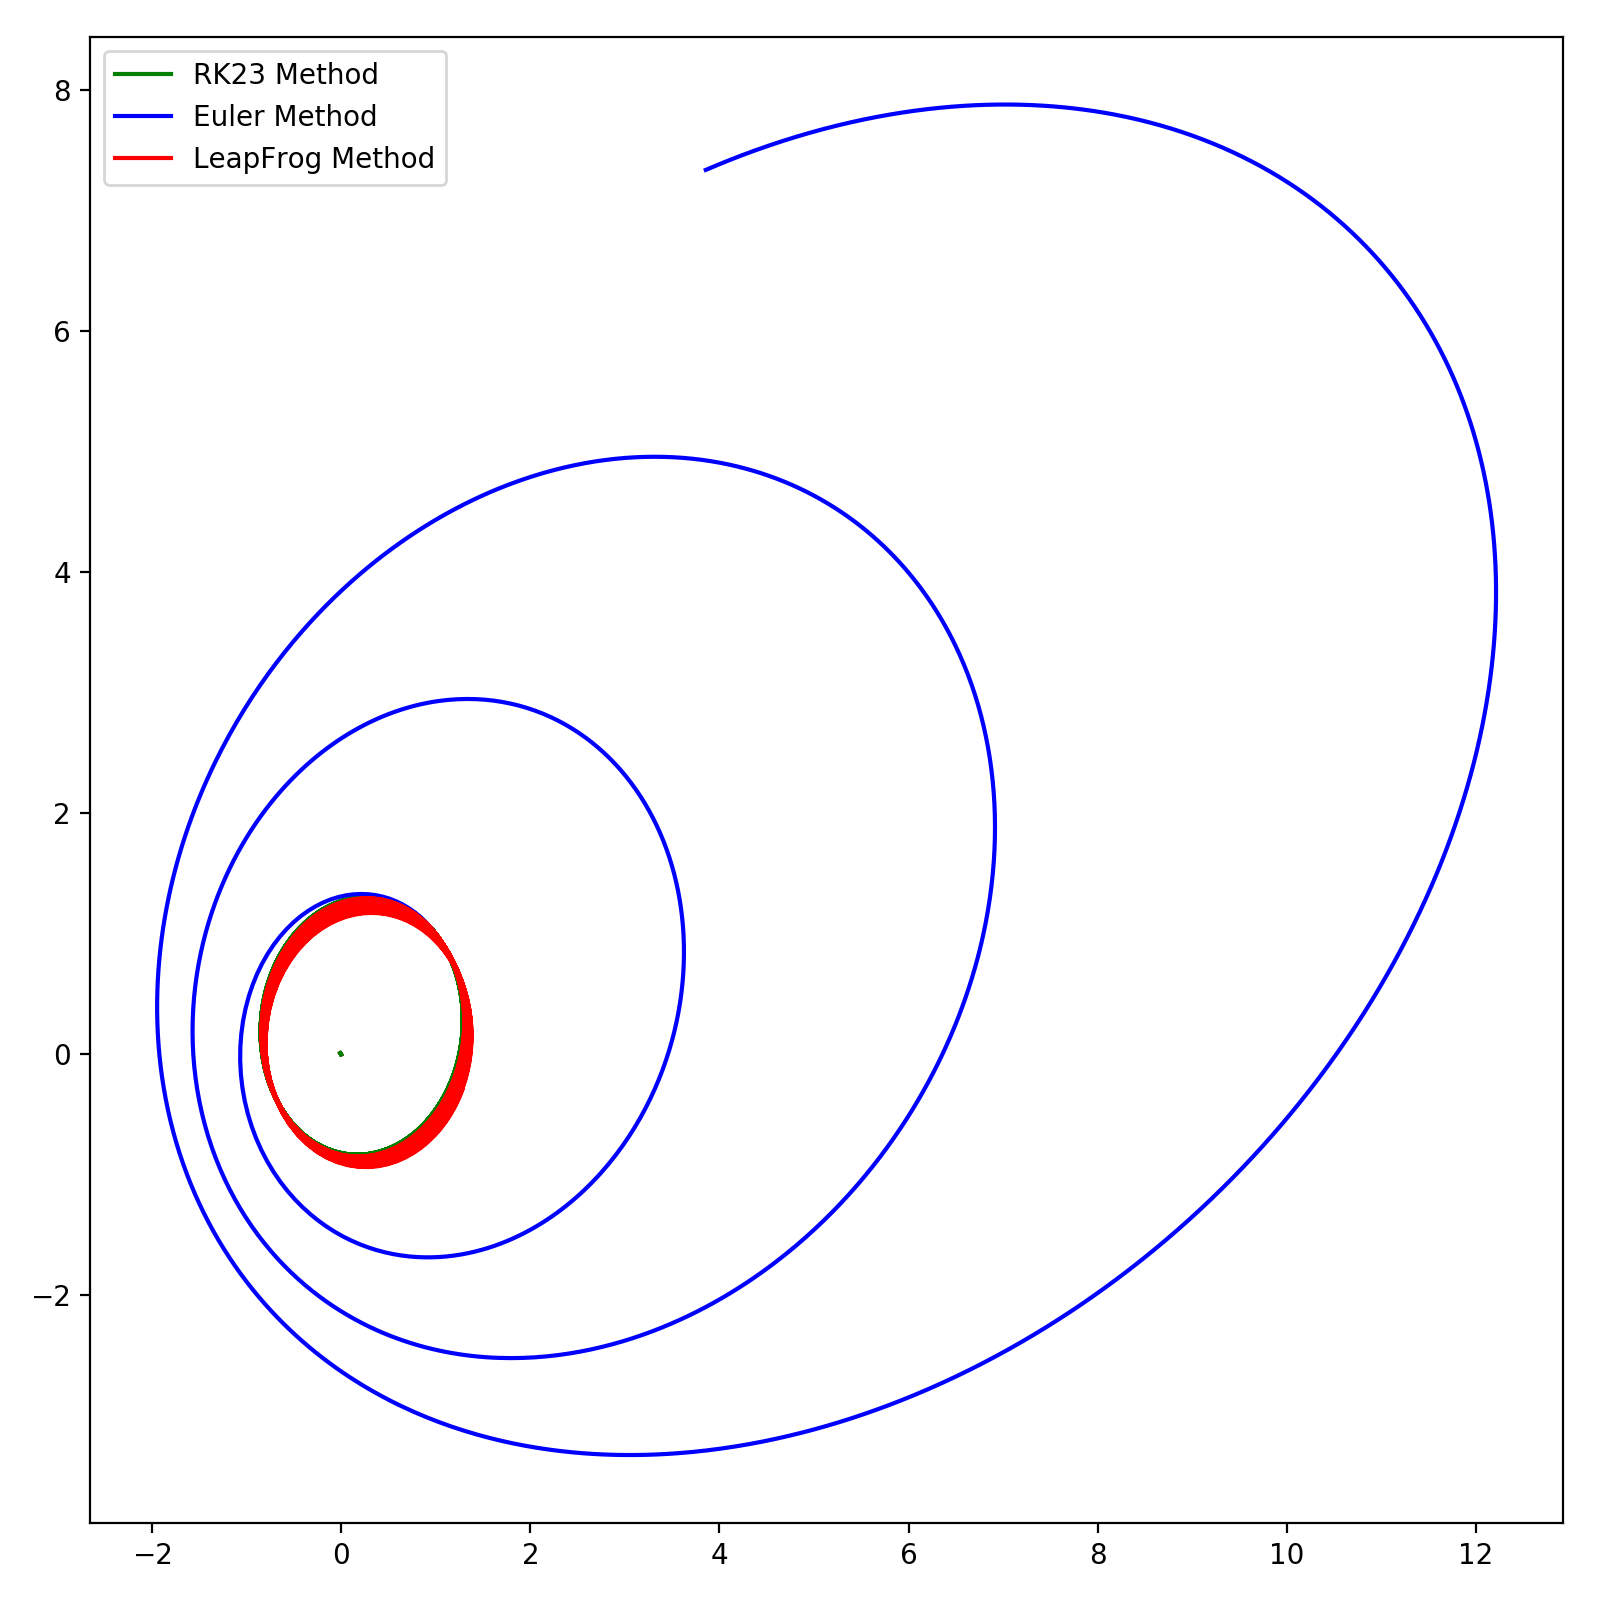

In [25]:
########## Plot
fig_2 = plt.figure(figsize=(8,8))

overall_title = 'Orbit:  ' + \
                rf' $m_1 = {o2.m1},$' + \
                rf' $m_2 = {o2.m2:.1f},$' + \
                rf' $G = {o2.G:.1f},$' + \
                rf' $X_{20} = {x2_0:.1f},$' + \
                rf' $Y_2 o= {y2_0:.1f},$' + \
                rf' $\dotX_2 o = {dx2_0:.1f},$' + \
                rf' $\dotY_2 o= {dy2_0:.1f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig_2.suptitle(overall_title, va='baseline')

ax_2a = fig_2.add_subplot(1,1,1)
ax_2a.plot(RK_q[0], RK_q[1], color='Orange', label=None)
ax_2a.plot(RK_q[2], RK_q[3], color='green', label='RK23 Method')

ax_2a.plot(E_q[0], E_q[1], color='black', label=None)
ax_2a.plot(E_q[2], E_q[3], color='blue', label='Euler Method')

ax_2a.plot(LF_q[0], LF_q[1], color='green', label=None)
ax_2a.plot(LF_q[2], LF_q[3], color='red', label='LeapFrog Method')

ax_2a.legend()

fig_2.tight_layout()

<IPython.core.display.Javascript object>


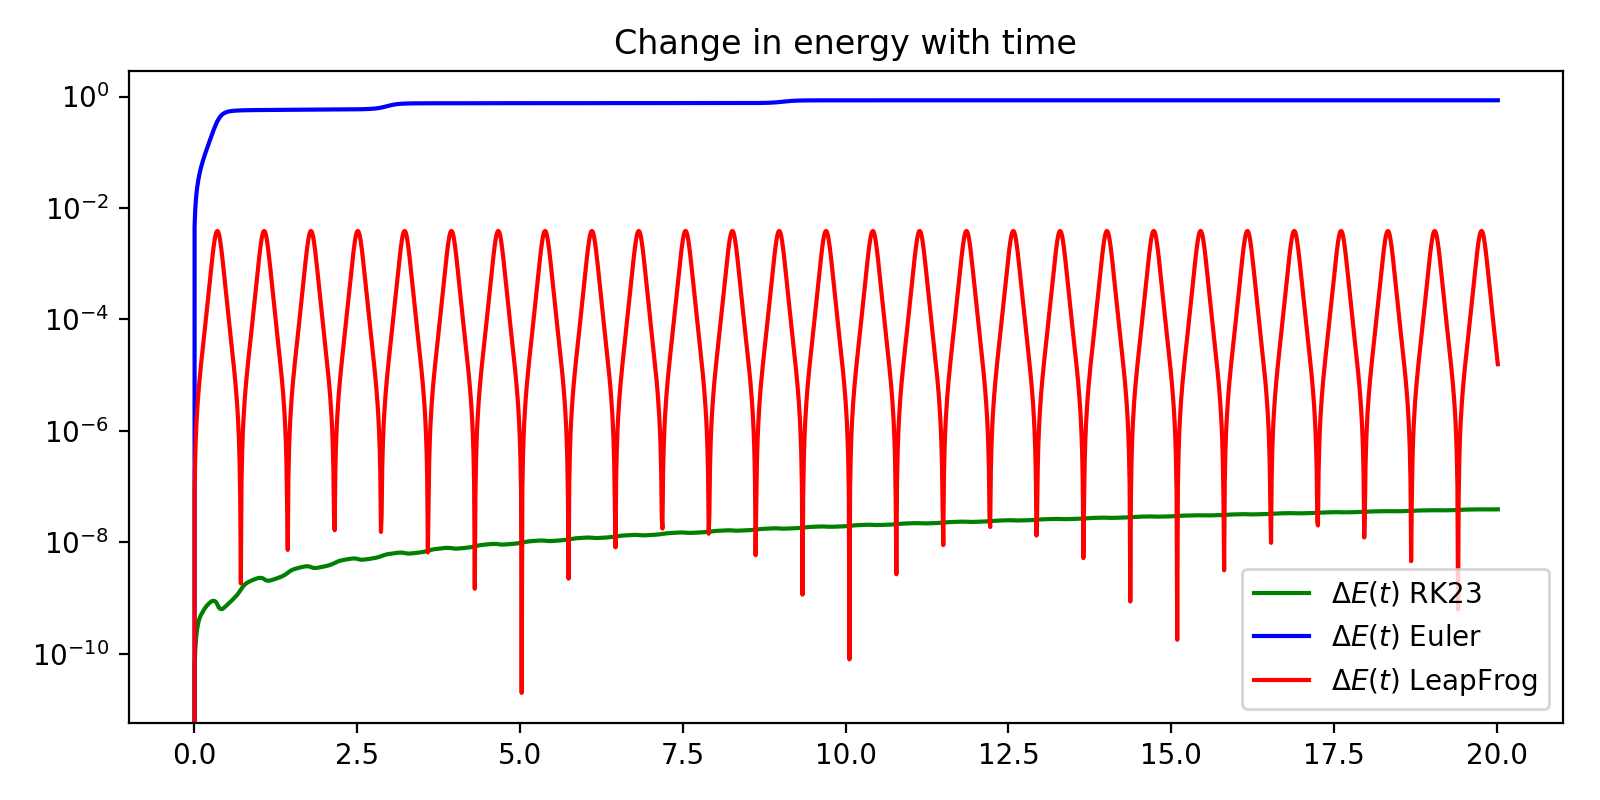

In [27]:
########## Plot
fig_3 = plt.figure(figsize=(8,4))

overall_title = 'Orbit:  ' + \
                '\n'     # \n means a new line (adds some space here)

fig_3.suptitle(overall_title, va='baseline')
ax_3a = fig_3.add_subplot(1,1,1)

### RK23 Method Plot
ax_3a.semilogy(t_pts, RK_E_pts, 
               color='green', label=r'$\Delta E(t)$ RK23')
### Euler Method Plot
ax_3a.semilogy(t_pts, Euler_E_pts, 
               color='blue', label=r'$\Delta E(t)$ Euler')
### LeapFrog Method Plot
ax_3a.semilogy(t_pts, LF_E_pts, 
               color='red', label=r'$\Delta E(t)$ LeapFrog')

ax_3a.legend()
ax_3a.set_title('Change in energy with time')

fig_3.tight_layout()

On average, the LeapFrog method is the only solver whose energy does not increase on average over time.

## Animation

Animating an orbit with matplotlib.

In [11]:
%matplotlib notebook
from matplotlib import animation, rc
from IPython.display import HTML

In [21]:
class AnimationOrbitPlot():
    """
    AnimationPlot class uses matplotlib.animation.FuncAnimation to animate
    the dynamics of a gravitational orbit.
     
    Methods
    -------
    t_pts_init
    
    add_orbit
        
    plot_init
    
    animate_Orbit
    
    start_Animation
    """
    
    def __init__(self, x1_vs_y1 = True, x2_vs_y2=True,
                 physical_orb = True):
        self.mass1 = 1.
                          
    def t_pts_init(self, t_start=0., t_end=100., delta_t=0.01): 
        """Create the array of time points for the full iteration"""
        self.t_start = t_start
        self.t_end = t_end
        self.delta_t = delta_t
        self.t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    def add_orbit(self, orb, q_0, dq_0):
        """Add a orbit to be plotted as a class instance of Orbit
            along with initial conditions.  So it knows all of the parameters
            as well through the Orbit class.
        """
        self.orb = orb
        q, dq = orb.solve_ode(self.t_pts, q_0, dq_0)
        
        self.x1 = q[0]
        self.y1 = q[1]
        self.x2 = q[2]
        self.y2 = q[3]    
        
    def plot_init(self):
        """
        Sets up the plot, paths (lines), and points (pts) to be animated
        """
        ###### Add a figure
        self.fig_4 = plt.figure(figsize=(4, 4), num='Orbit animation')
        
        ###### Add & customize an axis
        self.ax_4 = self.fig_4.add_subplot(1,1,1)        
        self.ax_4.set_xlabel(r'$x$')
        self.ax_4.set_ylabel(r'$y$')
        self.ax_4.set_xlim(1.2*np.min(self.x2), 1.2*np.max(self.x2))
        self.ax_4.set_ylim(1.2*np.min(self.y2), 1.2*np.max(self.y2))
        self.ax_4.set_aspect('equal')
        
        ###### Add empty lines. Will mark paths
        self.line1, = self.ax_4.plot([], [], '-', lw=1, color='orange')
        self.line2, = self.ax_4.plot([], [], '-', lw=1, color='blue')
        
        ###### Add points. Will mark current position of each mass
        self.pt1, = self.ax_4.plot([], [], 'o', ms=15, color='orange')
        self.pt2, = self.ax_4.plot([], [], 'o', ms=5, color='blue')
        
        self.fig_4.tight_layout()
        
    def animate_Orbit(self, i, start_index, skip): 
        """
        Function is fed into FuncAnimation to draw lines and points
        """
        # Current stop drawing index
        cInd = start_index + skip*i
        
        ###### Fill paths and current points of masses
        self.line1.set_data(self.x1[start_index:cInd:skip], 
                            self.y1[start_index:cInd:skip])
        self.pt1.set_data(self.x1[cInd-skip], self.y1[cInd-skip])
        
        self.line2.set_data(self.x2[start_index:cInd:skip], 
                            self.y2[start_index:cInd:skip])
        self.pt2.set_data(self.x2[cInd-skip], self.y2[cInd-skip])
    
        return self.line1, self.pt1, self.line2, self.pt2

    def start_Animation(self, plot_start, plot_end, skip_int,
                              interval):
        """
        Starts the animation when called with FuncAnimation
        """
        self.tI = plot_start
        self.tF = plot_end
        self.skip = skip_int
        self.interval = interval
        
        # Start index for plotting points
        self.t_str = np.where(self.t_pts == self.tI)[0][0]
        
        # Number of frames needed
        self.num_frames = int((self.tF - self.tI) / self.delta_t / self.skip)
        
        ###### Plot this mofo
        self.anim = animation.FuncAnimation(self.fig_4, 
                                            self.animate_Orbit,
                                            fargs=(self.t_str, self.skip),
                                            frames=self.num_frames,
                                            interval=self.interval, blit=False,
                                            repeat=False, save_count=0)
        self.fig_4.show()

In [22]:
########## Create a pendulum animation instance. 
orbit_anim = AnimationOrbitPlot()

###### Set up parameters & initial conditions
# Orbit Parameters
m1 = 1000.
m2 = .1
G = .1
o1 = Orbit(m1=m1, m2=m2, G=G)

# Plotting time 
t_start = 0.
t_end = 10.
delta_t = 0.001
orbit_anim.t_pts_init(t_start, t_end, delta_t)

########## Initial Conditions
x1_0 = 0.
dx1_0 = 0.
y1_0 = 0.
dy1_0 = 0.

x2_0 = 1.
dx2_0 = -5.
y2_0 = 1.
dy2_0 = 5.

q_0 = [x1_0, y1_0, x2_0, y2_0]
dq_0 = [dx1_0, dy1_0, dx2_0, dy2_0]

q_0 = [x1_0, y1_0, x2_0, y2_0]
dq_0 = [dx1_0, dy1_0, dx2_0, dy2_0]

###### Create Orbit
o3 = orbitSolvers(m1=m1, m2=m2, G=G)

# Add an orbit to the animation plots; this solves the differential
#  equation for the full t_pts array, generating q and dq/dt internally. 
orbit_anim.add_orbit(o3, q_0, dq_0)

<IPython.core.display.Javascript object>


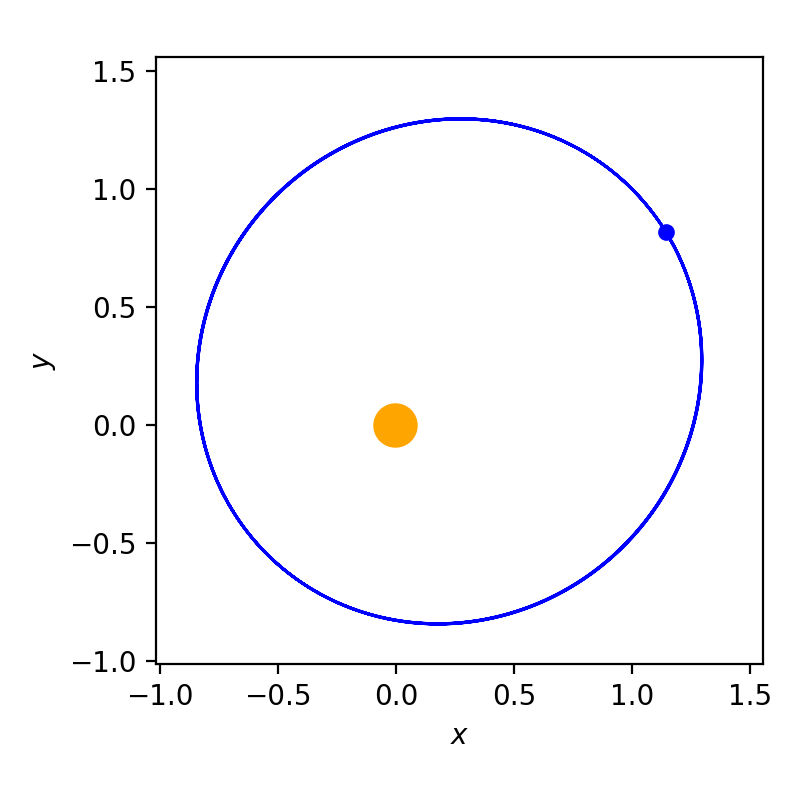

In [23]:
plot_start = 0.   # time to begin plotting
plot_end = 5.    # time to end plotting
orbit_anim.plot_init()

# Start the animation (adjust skip and interval for a smooth plot at a 
#  useful speed)
skip = 1       # skip between time points (in units of delta_t) 
interval = 1  # time between frames in milliseconds
orbit_anim.start_Animation(plot_start, plot_end, skip, interval)